In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dataa', 'datad', 'datac', 'datab', 'datae']


In [3]:
image_path = '../input/dataa/dataA/CameraRGB/'
mask_path = '../input/dataa/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
#name2id = {n:i for i, n in enumerate(classes)}
#id2name = {i:n for i, n in enumerate(classes)}

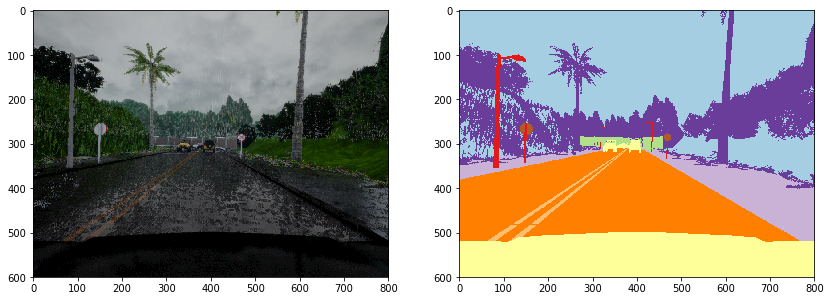

In [4]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[1].imshow(mask, cmap='Paired')

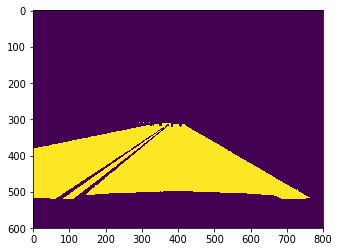

In [5]:
kk = np.zeros((600, 800))
kk[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(kk)

In [6]:
from tqdm import tqdm

In [7]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.float32)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.float32)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.float32)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

100%|██████████| 1000/1000 [00:47<00:00, 21.16it/s]


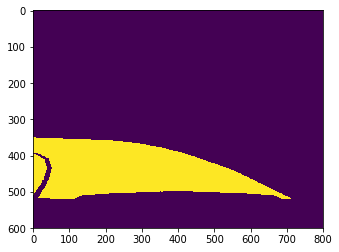

In [12]:
plt.imshow(masks[4].reshape(600, 800))

# Let's build U-Net

In [13]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [14]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 600, 800, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [15]:
callbacks = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(images, masks, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 86s 96ms/step - loss: 0.7085 - val_loss: 0.4152

Epoch 00001: val_loss improved from inf to 0.41516, saving model to model-sdc-seg-1.h5
Epoch 2/50
900/900 [==============================] - 73s 81ms/step - loss: 0.3722 - val_loss: 0.3651

Epoch 00002: val_loss improved from 0.41516 to 0.36506, saving model to model-sdc-seg-1.h5
Epoch 3/50
900/900 [==============================] - 73s 81ms/step - loss: 0.3242 - val_loss: 0.2893

Epoch 00003: val_loss improved from 0.36506 to 0.28929, saving model to model-sdc-seg-1.h5
Epoch 4/50
900/900 [==============================] - 73s 81ms/step - loss: 0.2559 - val_loss: 0.2666

Epoch 00004: val_loss improved from 0.28929 to 0.26662, saving model to model-sdc-seg-1.h5
Epoch 5/50
900/900 [==============================] - 73s 81ms/step - loss: 0.2089 - val_loss: 0.1995

Epoch 00005: val_loss improved from 0.26662 to 0.19946, saving model to model-s

900/900 [==============================] - 72s 80ms/step - loss: 0.0729 - val_loss: 0.0807

Epoch 00044: val_loss did not improve from 0.08040
Epoch 45/50
900/900 [==============================] - 72s 80ms/step - loss: 0.0724 - val_loss: 0.0794

Epoch 00045: val_loss improved from 0.08040 to 0.07941, saving model to model-sdc-seg-1.h5
Epoch 46/50
900/900 [==============================] - 72s 80ms/step - loss: 0.0719 - val_loss: 0.0793

Epoch 00046: val_loss improved from 0.07941 to 0.07929, saving model to model-sdc-seg-1.h5
Epoch 47/50
900/900 [==============================] - 72s 80ms/step - loss: 0.0713 - val_loss: 0.0783

Epoch 00047: val_loss improved from 0.07929 to 0.07834, saving model to model-sdc-seg-1.h5
Epoch 48/50
900/900 [==============================] - 72s 80ms/step - loss: 0.0715 - val_loss: 0.0780

Epoch 00048: val_loss improved from 0.07834 to 0.07795, saving model to model-sdc-seg-1.h5
Epoch 49/50
900/900 [==============================] - 72s 80ms/step - loss: 

In [16]:
model.save('final-road-segmentation.h5')

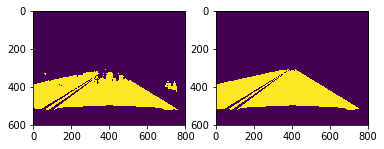

In [17]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[1].imshow(masks[NUMBER].reshape(600, 800))

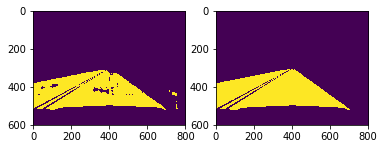

In [46]:
NUMBER += 1
my_preds = model.predict(np.expand_dims(images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[1].imshow(masks[NUMBER].reshape(600, 800))